# Enron fraud project

### Dataset
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project, we will play detectiveand and use machine learning skills to build a person of interest identifier based on financial and email data. To assist the detective work, a hand-generated list of persons of interest in the fraud case is provided, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.

The features in the data fall into three major types, namely financial features, email features and POI labels.

- financial features: 
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)
- email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
- POI label: [‘poi’] (boolean, represented as integer)


In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
sys.path.append("tools/")
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sb
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## 0. Required functions

In [2]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### featureFormat & targetFeatureSplit 
(from Udacity - Intro to ML)

A general tool for converting data from the dictionary format to an (n x k) python list that's ready for training an sklearn algorithm

n--no. of key-value pairs in dictonary

k--no. of features being extracted

dictionary keys are names of persons in dataset

dictionary values are dictionaries, where each key-value pair in the dict is the name of a feature, and its value for that person

In addition to converting a dictionary to a numpy array, you may want to separate the labels from the features--this is what targetFeatureSplit is for

So, if you want to have the poi label as the target, and the features you want to use are the person's salary and bonus, here's what you would do:

feature_list = ["poi", "salary", "bonus"] 

data_array = featureFormat( data_dictionary, feature_list )

label, features = targetFeatureSplit(data_array)

the line above (targetFeatureSplit) assumes that the label is the _first_ item in feature_list--very important that poi is listed first!


### tester
(from Udacity - Intro to ML)

a basic script for importing student's POI identifier, and checking the results that they get from it 
 
requires that the algorithm, dataset, and features list be written to my_classifier.pkl, my_dataset.pkl, and my_feature_list.pkl, respectively

that process should happen at the end of poi_id.py

## 1. Download data, check its structure & make dataframe

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

In [5]:
# Number of people in Enron dataset
len(data_dict.keys())

146

In [6]:
# Number of features in dictionary
len(data_dict[data_dict.keys()[0]])

21

How many guilty people are in the dataset? 

In [7]:
count=0
for i in data_dict.keys():
    #print enron_data[i]['poi']
    if data_dict[i]['poi']==True:
        count=count+1    
count

18

Convert enron_data to dataframe

In [8]:
features_list=data_dict['METTS MARK'].keys()
features_list

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [9]:
features_list= ['salary', 'to_messages',  'deferral_payments',
                'total_payments', 'exercised_stock_options',
                'bonus', 'restricted_stock', 'shared_receipt_with_poi',
                'restricted_stock_deferred', 'total_stock_value',
                'expenses', 'loan_advances', 'from_messages',
                'other', 'from_this_person_to_poi', 'poi',
                'director_fees', 'deferred_income', 'long_term_incentive',
                'from_poi_to_this_person']

In [10]:
data=featureFormat(data_dict, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, sort_keys = False)
target, features=targetFeatureSplit( data )

In [11]:
## make dataframe from the enron_data
enron_df=pd.DataFrame(data, columns=features_list ) 

xx=True
if xx==True:
    ## add person name to df 
    enron_df['name']=data_dict.keys()
    ## add person email to df
    enron_df['email_address']=np.nan
    for i in data_dict.keys():
        enron_df.loc[enron_df['name']==i, 'email_address']= data_dict[i]['email_address']
enron_df.head()  

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
0,365788.0,807.0,0.0,1061827.0,0.0,600000.0,585062.0,702.0,0.0,585062.0,...,29.0,1740.0,1.0,0.0,0.0,0.0,0.0,38.0,METTS MARK,mark.metts@enron.com
1,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,2660303.0,0.0,0.0,0.0,-1386055.0,1586055.0,0.0,BAXTER JOHN C,NaN
2,170941.0,0.0,0.0,211725.0,4890344.0,350000.0,1788391.0,0.0,0.0,6678735.0,...,0.0,12961.0,0.0,0.0,0.0,-400729.0,0.0,0.0,ELLIOTT STEVEN,steven.elliott@enron.com
3,0.0,764.0,0.0,0.0,651850.0,0.0,386335.0,58.0,0.0,1038185.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,CORDES WILLIAM R,bill.cordes@enron.com
4,243293.0,1045.0,0.0,288682.0,5538001.0,1500000.0,853064.0,1035.0,0.0,6391065.0,...,32.0,11350.0,21.0,1.0,0.0,-3117011.0,1617011.0,32.0,HANNON KEVIN P,kevin.hannon@enron.com


In [12]:
# remove 'poi' from features_list for further analysis 
features_list.remove('poi')

In [13]:
enron_df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,146.000000,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,146.000000
mean,3.658114e+05,1221.589041,4.387965e+05,4.350622e+06,4.182736e+06,1.333474e+06,1.749257e+06,692.986301,2.051637e+04,5.846018e+06,7.074827e+04,1.149658e+06,358.602740,5.854318e+05,24.287671,0.123288,1.942249e+04,-3.827622e+05,6.646839e+05,38.226027
std,2.203575e+06,2226.770637,2.741325e+06,2.693448e+07,2.607040e+07,8.094029e+06,1.089995e+07,1072.969492,1.439661e+06,3.624681e+07,4.327163e+05,9.649342e+06,1441.259868,3.682345e+06,79.278206,0.329899,1.190543e+05,2.378250e+06,4.046072e+06,73.901124
min,0.000000e+00,0.000000,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,0.000000,-7.576788e+06,-4.409300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-2.799289e+07,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,9.394475e+04,0.000000e+00,0.000000e+00,8.115000e+03,0.000000,0.000000e+00,2.288695e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-3.792600e+04,0.000000e+00,0.000000
50%,2.105960e+05,289.000000,0.000000e+00,9.413595e+05,6.082935e+05,3.000000e+05,3.605280e+05,102.500000,0.000000e+00,9.659550e+05,2.018200e+04,0.000000e+00,16.500000,9.595000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000
75%,2.708505e+05,1585.750000,9.684500e+03,1.968287e+06,1.714221e+06,8.000000e+05,8.145280e+05,893.500000,0.000000e+00,2.319991e+06,5.374075e+04,0.000000e+00,51.250000,1.506065e+05,13.750000,0.000000,0.000000e+00,0.000000e+00,3.750648e+05,40.750000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.000000,1.398517e+06,0.000000e+00,4.852193e+07,528.000000


Negative Values to be checked and corrected

In [14]:
enron_df[enron_df['deferral_payments']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
24,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,...,0.0,0.0,0.0,0.0,3285.0,0.0,0.0,0.0,BELFER ROBERT,NaN


In [15]:
enron_df[enron_df['restricted_stock']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
118,0.0,523.0,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.0,15456290.0,0.0,...,29.0,137864.0,1.0,0.0,137864.0,0.0,0.0,0.0,BHATNAGAR SANJAY,sanjay.bhatnagar@enron.com


In [16]:
enron_df[enron_df['restricted_stock_deferred']<0].shape[0]

16

In [17]:
enron_df[enron_df['total_stock_value']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
24,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,...,0.0,0.0,0.0,0.0,3285.0,0.0,0.0,0.0,BELFER ROBERT,NaN


In [18]:
enron_df[enron_df['deferred_income']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
1,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,2660303.0,0.0,0.0,0.0,-1386055.0,1586055.0,0.0,BAXTER JOHN C,NaN
2,170941.0,0.0,0.0,211725.0,4890344.0,350000.0,1788391.0,0.0,0.0,6678735.0,...,0.0,12961.0,0.0,0.0,0.0,-400729.0,0.0,0.0,ELLIOTT STEVEN,steven.elliott@enron.com
4,243293.0,1045.0,0.0,288682.0,5538001.0,1500000.0,853064.0,1035.0,0.0,6391065.0,...,32.0,11350.0,21.0,1.0,0.0,-3117011.0,1617011.0,32.0,HANNON KEVIN P,kevin.hannon@enron.com
9,197091.0,1238.0,1130036.0,1737629.0,880290.0,400000.0,409554.0,742.0,-409554.0,880290.0,...,222.0,778.0,48.0,0.0,0.0,-33333.0,0.0,61.0,PIPER GREGORY F,greg.piper@enron.com
16,288542.0,1758.0,27610.0,1490344.0,0.0,1200000.0,698242.0,1132.0,0.0,698242.0,...,40.0,101740.0,11.0,1.0,0.0,-144062.0,0.0,240.0,COLWELL WESLEY,wes.colwell@enron.com
17,251654.0,136.0,842924.0,3202070.0,1056320.0,1100000.0,360528.0,114.0,0.0,1416848.0,...,16.0,947.0,0.0,0.0,0.0,-719000.0,1725545.0,12.0,MULLER MARK S,s..muller@enron.com
19,63744.0,0.0,0.0,762135.0,0.0,0.0,384930.0,0.0,0.0,384930.0,...,0.0,401130.0,0.0,0.0,0.0,-10800.0,256191.0,0.0,WESTFAHL RICHARD K,dick.westfahl@enron.com
23,0.0,0.0,0.0,0.0,0.0,0.0,32460.0,0.0,-32460.0,0.0,...,0.0,0.0,0.0,0.0,98784.0,-98784.0,0.0,0.0,CHAN RONNIE,NaN
27,187922.0,383.0,0.0,618850.0,0.0,250000.0,659249.0,233.0,0.0,659249.0,...,59.0,427316.0,0.0,0.0,0.0,-485813.0,180250.0,4.0,BERGSIEKER RICHARD P,rick.bergsieker@enron.com
28,0.0,0.0,0.0,228656.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,36666.0,-36666.0,0.0,0.0,URQUHART JOHN A,NaN


In [19]:
enron_df[enron_df['deferred_income']<0].shape[0]

49

In [20]:
data_dict['BELFER ROBERT']

{'bonus': 'NaN',
 'deferral_payments': -102500,
 'deferred_income': 'NaN',
 'director_fees': 3285,
 'email_address': 'NaN',
 'exercised_stock_options': 3285,
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 44093,
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 102500,
 'total_stock_value': -44093}

While comparing the dataframe entry with enron61702insiderpay.pdf we can see that values are shifted, so we will change values for BELFER ROBERT manually.

In [21]:
data_dict['BELFER ROBERT']['deferred_income']= -102500
data_dict['BELFER ROBERT']['deferral_payments']= 0
data_dict['BELFER ROBERT']['expenses']=3285
data_dict['BELFER ROBERT']['director_fees']= 102500
data_dict['BELFER ROBERT']['total_payments']=3285
data_dict['BELFER ROBERT']['exercised_stock_options']= 0
data_dict['BELFER ROBERT']['restricted_stock']=44093
data_dict['BELFER ROBERT']['restricted_stock_deferred']=-44093,
data_dict['BELFER ROBERT']['total_stock_value']= 0

In [22]:
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'deferred_income']=-102500
enron_df.loc[enron_df['name']=='BELFER ROBERT','deferral_payments']= 0
enron_df.loc[enron_df['name']=='BELFER ROBERT','expenses']=3285
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'director_fees']= 102500
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'total_payments']=3285
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'exercised_stock_options']= 0
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'restricted_stock']=44093
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'restricted_stock_deferred']=-44093
enron_df.loc[enron_df['name']=='BELFER ROBERT', 'total_stock_value']= 0

In [23]:
data_dict['BHATNAGAR SANJAY']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 137864,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'exercised_stock_options': 2604490,
 'expenses': 'NaN',
 'from_messages': 29,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 137864,
 'poi': False,
 'restricted_stock': -2604490,
 'restricted_stock_deferred': 15456290,
 'salary': 'NaN',
 'shared_receipt_with_poi': 463,
 'to_messages': 523,
 'total_payments': 15456290,
 'total_stock_value': 'NaN'}

the same as with previous record. While comparing the dataframe entry with enron61702insiderpay.pdf we can see that values are shifted, so we will change values for BHATNAGAR SANJAY manually.

In [24]:
data_dict['BHATNAGAR SANJAY']['other']= 0
data_dict['BHATNAGAR SANJAY']['expenses']=137864
data_dict['BHATNAGAR SANJAY']['director_fees']=0
data_dict['BHATNAGAR SANJAY']['total_payments']= 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options']= 15456290
data_dict['BHATNAGAR SANJAY']['restricted_stock']=   2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred']= -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value']=15456290    

In [25]:
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','other']= 0
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','expenses']=137864
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','director_fees']=0
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','total_payments']= 137864
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','exercised_stock_options']= 15456290
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','restricted_stock']=   2604490
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','restricted_stock_deferred']= -2604490
enron_df.loc[enron_df['name']=='BHATNAGAR SANJAY','total_stock_value']=15456290  

In [26]:
enron_df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,146.000000,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,146.000000
mean,3.658114e+05,1221.589041,4.394986e+05,4.245022e+06,4.270740e+06,1.333474e+06,1.785237e+06,692.986301,-1.037916e+05,5.952185e+06,7.171504e+04,1.149658e+06,358.602740,5.844875e+05,24.287671,0.123288,1.915777e+04,-3.834643e+05,6.646839e+05,38.226027
std,2.203575e+06,2226.770637,2.741199e+06,2.692086e+07,2.608673e+07,8.094029e+06,1.089408e+07,1072.969492,6.792772e+05,3.625214e+07,4.327076e+05,9.649342e+06,1441.259868,3.682478e+06,79.278206,0.329899,1.188508e+05,2.378151e+06,4.046072e+06,73.901124
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-7.576788e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-2.799289e+07,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,8.839225e+04,0.000000e+00,0.000000e+00,4.409300e+04,0.000000,0.000000e+00,2.534955e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.052400e+04,0.000000e+00,0.000000
50%,2.105960e+05,289.000000,0.000000e+00,9.138250e+05,6.082935e+05,3.000000e+05,3.619780e+05,102.500000,0.000000e+00,9.805345e+05,2.193700e+04,0.000000e+00,16.500000,9.190000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000
75%,2.708505e+05,1585.750000,9.684500e+03,1.917959e+06,1.714221e+06,8.000000e+05,8.651810e+05,893.500000,0.000000e+00,2.453312e+06,5.480950e+04,0.000000e+00,51.250000,1.506065e+05,13.750000,0.000000,0.000000e+00,0.000000e+00,3.750648e+05,40.750000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,0.000000e+00,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.000000,1.398517e+06,0.000000e+00,4.852193e+07,528.000000


'YEAP SOON' and 'THE TRAVEL AGENCY IN THE PARK' look like imaginary names, let's check

In [27]:
data_dict['YEAP SOON']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 192758,
 'expenses': 55097,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 55097,
 'total_stock_value': 192758}

In [28]:
data_dict['THE TRAVEL AGENCY IN THE PARK']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

Let's delete this records as well

In [29]:
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0) 
enron_df=enron_df.drop(enron_df[enron_df['name']=='THE TRAVEL AGENCY IN THE PARK'].index[0], axis=0)
data_dict.pop('YEAP SOON', 0) 
enron_df=enron_df.drop(enron_df[enron_df['name']=='YEAP SOON'].index[0], axis=0)

## 2. Remove outliers

In [30]:
# use base color for plotting
base_color = sb.color_palette()[0]

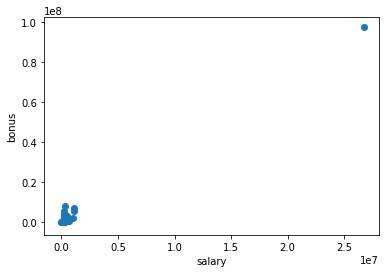

In [31]:
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus, c=base_color )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [32]:
enron_df[enron_df['salary']>25000000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
104,26704229.0,0.0,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,0.0,-7576788.0,434509511.0,...,0.0,42667589.0,0.0,0.0,1398517.0,-27992891.0,48521928.0,0.0,TOTAL,NaN


Remove TOTAL from data

In [33]:
data_dict.pop('TOTAL', 0) 
enron_df=enron_df.drop(enron_df[enron_df['name']=='TOTAL'].index[0], axis=0)

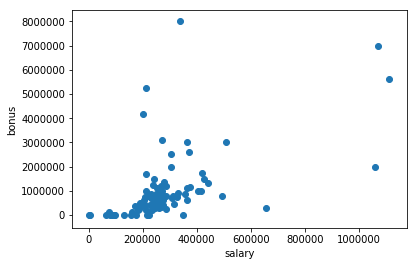

In [34]:
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus, c=base_color )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

Let's check oyther high values, it seems that it's real people, so we don't need to delet this points

In [35]:
enron_df[enron_df['bonus']>5*10**6]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
43,339288.0,7259.0,0.0,10425757.0,4158995.0,8000000.0,1008149.0,3962.0,0.0,5167144.0,...,2585.0,1552.0,411.0,0.0,0.0,0.0,2035380.0,528.0,LAVORATO JOHN J,john.lavorato@enron.com
65,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,...,36.0,10359729.0,16.0,1.0,0.0,-300000.0,3600000.0,123.0,LAY KENNETH L,kenneth.lay@enron.com
82,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,0.0,1110705.0,...,484.0,210698.0,108.0,1.0,0.0,-2334434.0,0.0,228.0,BELDEN TIMOTHY N,tim.belden@enron.com
95,1111258.0,3627.0,0.0,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,0.0,26093672.0,...,108.0,22122.0,30.0,1.0,0.0,0.0,1920000.0,88.0,SKILLING JEFFREY K,jeff.skilling@enron.com


In [36]:
enron_df.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'restricted_stock_deferred',
       u'total_stock_value', u'expenses', u'loan_advances', u'from_messages',
       u'other', u'from_this_person_to_poi', u'poi', u'director_fees',
       u'deferred_income', u'long_term_incentive', u'from_poi_to_this_person',
       u'name', u'email_address'],
      dtype='object')

**Empty records**

In [37]:
enron_df[enron_df[enron_df==0].count(axis=1)/enron_df.shape[1]>0.8]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,name,email_address
26,0.0,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,WODRASKA JOHN,john.wodraska@enron.com
31,0.0,0.0,0.0,0.0,98718.0,0.0,0.0,0.0,0.0,98718.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WHALEY DAVID A,NaN
62,0.0,0.0,0.0,0.0,139130.0,0.0,0.0,0.0,0.0,139130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WROBEL BRUCE,NaN
73,0.0,0.0,0.0,0.0,759557.0,0.0,0.0,0.0,0.0,759557.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCRIMSHAW MATTHEW,matthew.scrimshaw@enron.com
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LOCKHART EUGENE E,NaN
141,0.0,0.0,0.0,119292.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,119292.0,0.0,0.0,0.0,GRAMM WENDY L,NaN


'LOCKHART EUGENE E' record is empty, thus can be removed. Others have 2 identical values. 

In [38]:
enron_df.drop(enron_df[enron_df['name']=='LOCKHART EUGENE E'].index[0], inplace=True)

## 3. Create new feature(s)

to_poi_fraction, from_poi_fraction, salary/bonus_fraction

In [39]:
enron_df['to_poi_fraction'] = enron_df['from_this_person_to_poi'] / enron_df['from_messages']
enron_df['to_poi_fraction']=enron_df['to_poi_fraction'].fillna(0)
enron_df['to_poi_fraction'].replace(np.inf, 0, inplace=True)
enron_df[['to_poi_fraction','from_this_person_to_poi','from_messages'] ].head()

,to_poi_fraction,from_this_person_to_poi,from_messages
0,0.034483,1.0,29.0
1,0.000000,0.0,0.0
2,0.000000,0.0,0.0
3,0.000000,0.0,12.0
4,0.656250,21.0,32.0


In [40]:
enron_df['from_poi_fraction'] = enron_df['from_poi_to_this_person'] / enron_df['to_messages']
enron_df['from_poi_fraction']=enron_df['from_poi_fraction'].fillna(0)
enron_df['from_poi_fraction'].replace(np.inf, 0, inplace=True)
enron_df[['from_poi_fraction','from_poi_to_this_person','to_messages'] ].head()

,from_poi_fraction,from_poi_to_this_person,to_messages
0,0.047088,38.0,807.0
1,0.000000,0.0,0.0
2,0.000000,0.0,0.0
3,0.013089,10.0,764.0
4,0.030622,32.0,1045.0


In [41]:
enron_df['salary_bonus_fraction']=enron_df['salary']/enron_df['bonus'] 
enron_df['salary_bonus_fraction']=enron_df['salary_bonus_fraction'].fillna(0)
enron_df['salary_bonus_fraction'].replace(np.inf, 0, inplace=True)
enron_df[['salary_bonus_fraction', 'salary', 'bonus']].head()

,salary_bonus_fraction,salary,bonus
0,0.609647,365788.0,600000.0
1,0.222585,267102.0,1200000.0
2,0.488403,170941.0,350000.0
3,0.000000,0.0,0.0
4,0.162195,243293.0,1500000.0


In [42]:
print len(features_list)
x=True
if x==True:
# add new features to features_list
    features_list.extend(['to_poi_fraction', 'from_poi_fraction', 'salary_bonus_fraction'])
    print features_list
len(features_list)

19
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'to_poi_fraction', 'from_poi_fraction', 'salary_bonus_fraction']


22

'deffered_income' and 'restricted_stock_deffered' features are negarive, make it positive for SelectKbest

In [43]:
enron_df['deferred_income']=-1*enron_df['deferred_income']
enron_df['restricted_stock_deferred']=-1*enron_df['restricted_stock_deferred']
enron_df['restricted_stock_deferred'].replace(-0.0, 0, inplace=True)
enron_df['deferred_income'].replace(-0.0, 0, inplace=True)

### Single variable visualisation

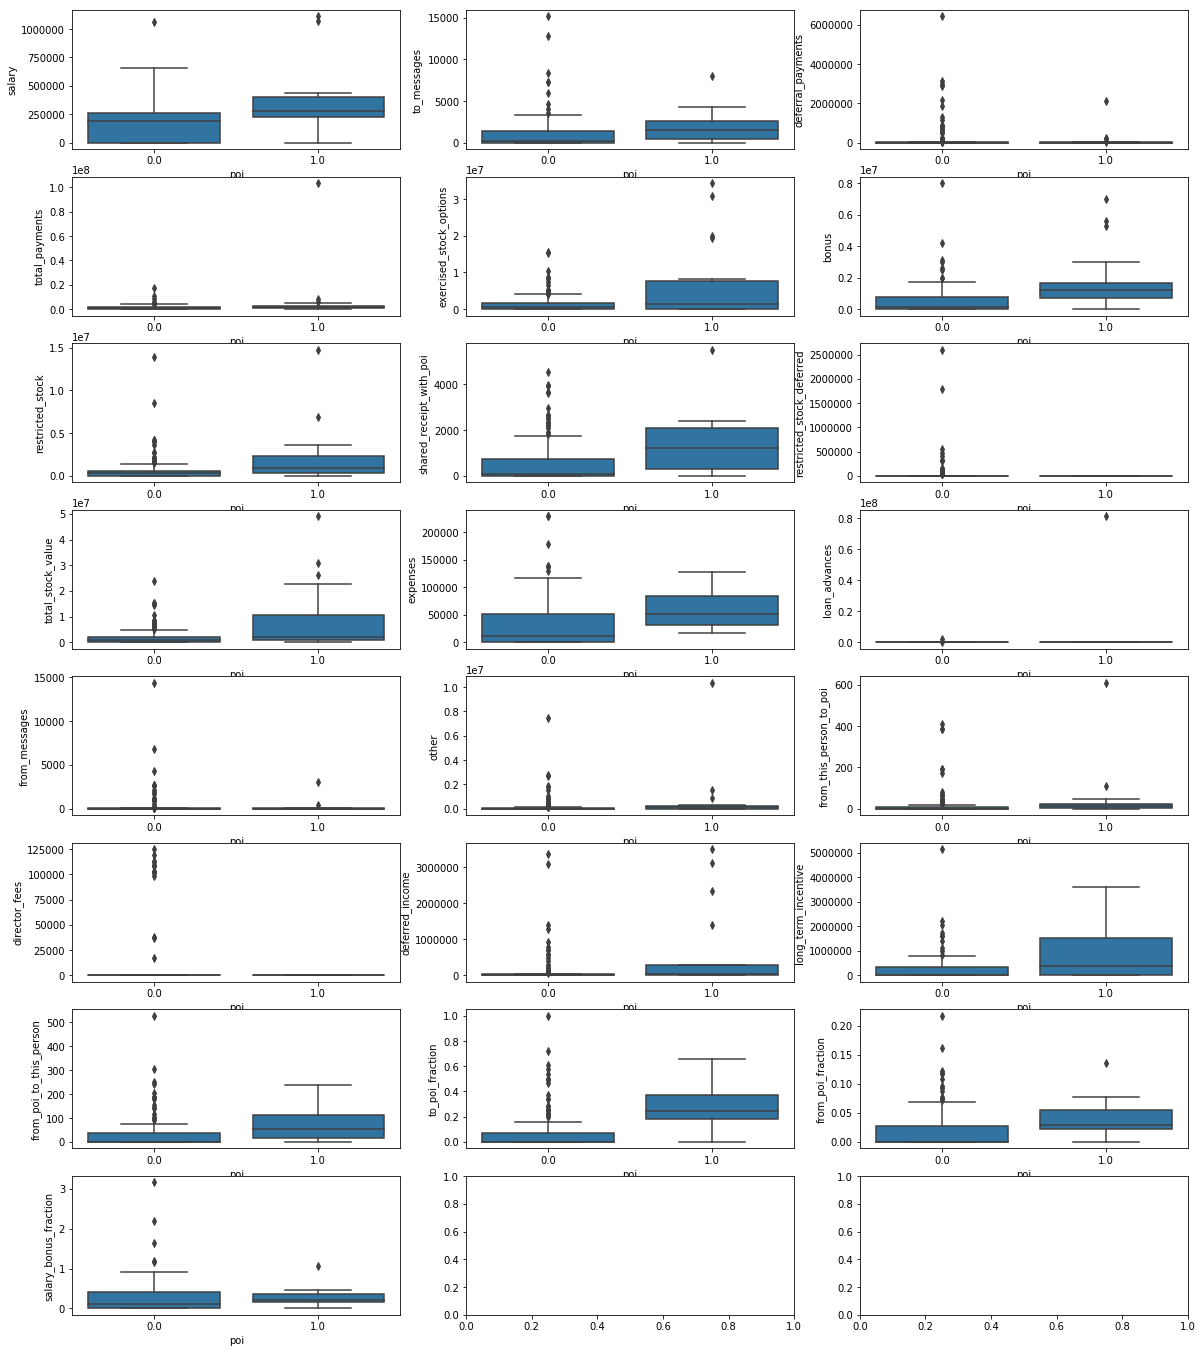

In [44]:
numeric_columns=['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi',  'director_fees',
       'deferred_income', u'long_term_incentive', 'from_poi_to_this_person',
       'to_poi_fraction', 'from_poi_fraction',
       'salary_bonus_fraction']
fig, ax = plt.subplots(8,3,figsize=(20,24))
k=0
for i in range(8):
    #print enron_df.columns[i]
    for j in range(3):
        enron_df.columns[j]
        sb.boxplot(data = enron_df, x = 'poi', y = numeric_columns[k],  color=base_color, ax=ax[i,j]); 
        #ax[i,j].legend(loc=(0.01, 0.075) ,fontsize = 8);
        #ax[i.j].set_xlabel('principal component')   
        #ax[1.1].set_title('Zoomed') 
        k=k+1
        if k==22:
            break       

'total_payments' are higher for POIs

(-1000000, 10000000)

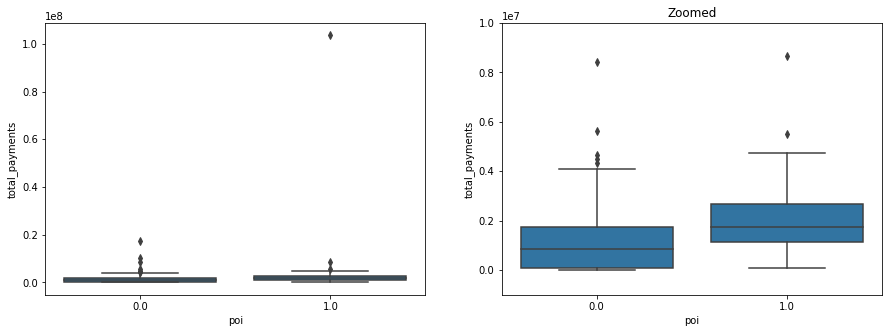

In [45]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    sb.boxplot(data = enron_df, x = 'poi', y = 'total_payments',  color=base_color, ax=ax[i]);   
ax[1].set_title('Zoomed')    
ax[1].set_ylim(-1000000,10000000)


'from_messages' - a bit more from messages between POIs than from POI to non-POI  

(-100, 500)

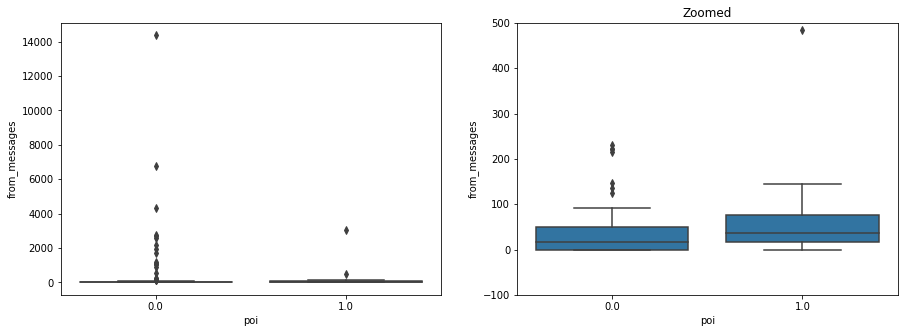

In [46]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    sb.boxplot(data = enron_df, x = 'poi', y = 'from_messages',  color=base_color, ax=ax[i]); 
ax[1].set_title('Zoomed')    
ax[1].set_ylim(-100,500)

from_this_person_to_poi

(-10, 100)

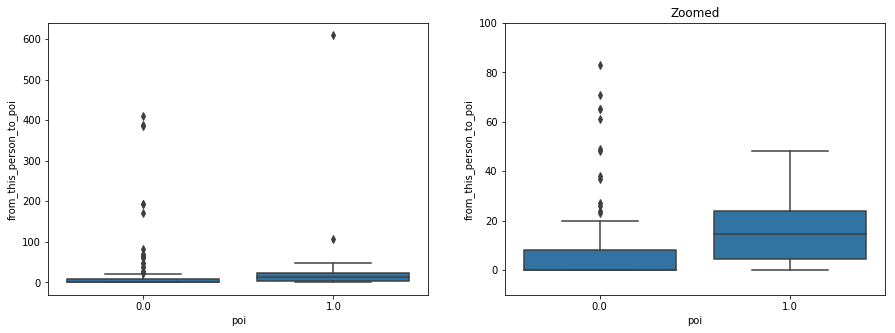

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    sb.boxplot(data = enron_df, x = 'poi', y = 'from_this_person_to_poi',  color=base_color, ax=ax[i]); 
ax[1].set_title('Zoomed')    
ax[1].set_ylim(-10,100)

deferred_income

(-10000, 500000)

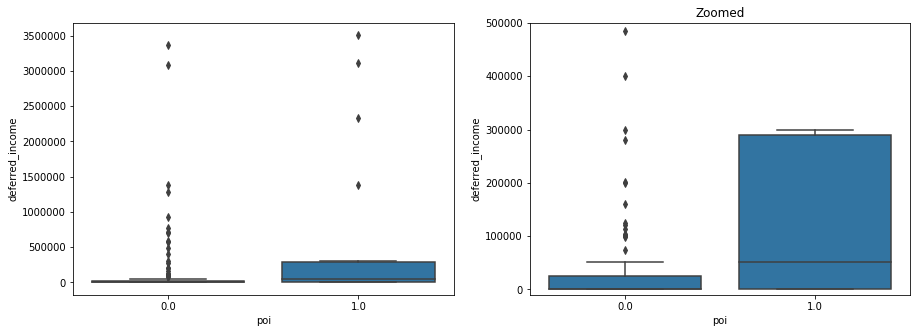

In [48]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    sb.boxplot(data = enron_df, x = 'poi', y = 'deferred_income',  color=base_color, ax=ax[i]); 
ax[1].set_title('Zoomed')    
ax[1].set_ylim(-10000,500000)

List of almost empty columns (%)

In [49]:
enron_df[enron_df==0].count()/enron_df.shape[0]*100

salary                       33.802817
to_messages                  39.436620
deferral_payments            73.943662
total_payments               14.084507
exercised_stock_options      30.281690
bonus                        42.957746
restricted_stock             22.535211
shared_receipt_with_poi      39.436620
restricted_stock_deferred    88.028169
total_stock_value            12.676056
expenses                     33.098592
loan_advances                97.887324
from_messages                39.436620
other                        36.619718
from_this_person_to_poi      53.521127
poi                          87.323944
director_fees                89.436620
deferred_income              65.492958
long_term_incentive          54.225352
from_poi_to_this_person      47.887324
name                          0.000000
email_address                 0.000000
to_poi_fraction              53.521127
from_poi_fraction            47.887324
salary_bonus_fraction        42.957746
dtype: float64

### Split data to test train 

In [50]:
features_train, features_test, labels_train, labels_test = train_test_split(
    enron_df[features_list], enron_df['poi'], test_size=0.3, random_state=42)


In [51]:
features_train.shape

(99, 22)

### Normalise train/test data: MinMaxScaler 

In [52]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(features_train[features_list])
features_train_norm=pd.DataFrame(mm_scaler.transform(features_train[features_list]),columns=features_list)
features_test_norm=pd.DataFrame(mm_scaler.transform(features_test[features_list]),columns=features_list)

### Normalise data: StandardScaler

In [53]:
from sklearn.preprocessing import StandardScaler
sc_scaler=StandardScaler()
sc_scaler.fit(features_train[features_list])
features_train_norm_sc=pd.DataFrame(sc_scaler.transform(features_train[features_list]),columns=features_list)
features_test_norm_sc=pd.DataFrame(sc_scaler.transform(features_test[features_list]),columns=features_list)

## 4. Features selection

### PCA

In [54]:
enron_df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,to_poi_fraction,from_poi_fraction,salary_bonus_fraction
count,1.420000e+02,142.000000,1.420000e+02,1.420000e+02,1.420000e+02,1.420000e+02,1.420000e+02,142.000000,1.420000e+02,1.420000e+02,...,1.420000e+02,142.000000,142.000000,142.000000,1.420000e+02,1.420000e+02,142.000000,142.000000,142.000000,142.000000
mean,1.880580e+05,1256.000000,2.259394e+05,2.179362e+06,2.194164e+06,6.855184e+05,9.177627e+05,712.507042,5.335766e+04,3.058569e+06,...,2.979260e+05,24.971831,0.126761,9848.711268,1.971330e+05,3.417037e+05,39.302817,0.111470,0.022992,0.276288
std,1.971843e+05,2248.476742,7.586983e+05,8.837746e+06,4.951890e+06,1.239221e+06,2.011567e+06,1081.626637,2.750417e+05,6.306116e+06,...,1.138969e+06,80.287775,0.333882,30615.388119,6.096782e+05,6.908581e+05,74.657135,0.186784,0.036574,0.418177
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,9.620200e+04,0.000000e+00,0.000000e+00,5.443750e+04,0.000000,0.000000e+00,3.248138e+05,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,2.112400e+05,391.500000,0.000000e+00,9.413595e+05,6.224980e+05,3.000000e+05,3.643740e+05,115.500000,0.000000e+00,9.860165e+05,...,9.190000e+02,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.500000,0.000000,0.005137,0.157692
75%,2.708505e+05,1655.000000,9.684500e+03,1.917959e+06,1.714221e+06,8.000000e+05,8.651810e+05,1001.250000,0.000000e+00,2.453312e+06,...,1.498310e+05,14.000000,0.000000,0.000000,4.052400e+04,3.750648e+05,41.750000,0.199609,0.030121,0.411267
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,2.604490e+06,4.911008e+07,...,1.035973e+07,609.000000,1.000000,125034.000000,3.504386e+06,5.145434e+06,528.000000,1.000000,0.217341,3.157186


In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(enron_df[features_list])
enron_norm_df=pd.DataFrame(scaler.transform(enron_df[features_list]),columns=features_list)

pca= PCA()
pca.fit(enron_norm_df[features_list])
print(pca.explained_variance_ratio_)

[2.92315036e-01 1.24982715e-01 1.11601808e-01 8.82480433e-02
 7.13320777e-02 6.05962204e-02 4.41424667e-02 3.72493254e-02
 3.03144090e-02 2.65936961e-02 2.32942324e-02 1.90231007e-02
 1.57741873e-02 1.38876259e-02 1.31332660e-02 9.65596437e-03
 6.99145948e-03 5.45865070e-03 3.21144151e-03 2.19427329e-03
 1.23433400e-33 2.84401922e-34]


(0.01, 1)

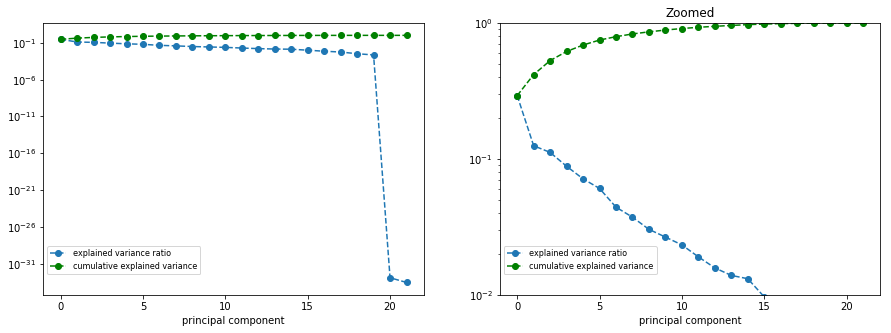

In [56]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    ax[i].semilogy(pca.explained_variance_ratio_, '--o', label = 'explained variance ratio')
    ax[i].semilogy(pca.explained_variance_ratio_.cumsum(), '--go',
                   label = 'cumulative explained variance');   
    ax[i].legend(loc=(0.01, 0.075) ,fontsize = 8);
    ax[i].set_xlabel('principal component')   
ax[1].set_title('Zoomed')    

ax[1].set_ylim(0.01,1)


<font color='red'>Add description here!</font>

### Filter Methods for features selection

In [57]:
correlated_features = set()  
correlation_matrix = features_train.corr()  

In [58]:
correlation_matrix

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,to_poi_fraction,from_poi_fraction,salary_bonus_fraction
salary,1.000000,0.400009,0.315596,0.727826,0.300600,0.565141,0.409302,0.499654,-0.118727,0.388042,...,0.140705,0.467033,0.212366,-0.333163,0.368407,0.487467,0.397004,0.333283,0.284581,0.364086
to_messages,0.400009,1.000000,0.191615,0.434925,0.008195,0.609191,0.112150,0.894652,-0.055108,0.045836,...,0.576352,0.046479,0.828767,-0.204562,0.166841,0.166416,0.743876,0.153106,0.247661,-0.040670
deferral_payments,0.315596,0.191615,1.000000,0.635633,0.133997,0.236841,0.115831,0.291470,0.074400,0.148248,...,0.028934,0.605425,0.005696,-0.106505,0.661803,0.158739,0.284636,0.031105,0.176596,-0.015772
total_payments,0.727826,0.434925,0.635633,1.000000,0.264156,0.682585,0.322838,0.562833,-0.062935,0.327780,...,0.088713,0.723003,0.271915,-0.223672,0.463869,0.652019,0.598606,0.207491,0.299677,0.029156
exercised_stock_options,0.300600,0.008195,0.133997,0.264156,1.000000,0.220881,0.372897,0.040731,-0.054801,0.948371,...,-0.049345,0.231168,-0.027374,-0.167230,0.275504,0.200570,0.085251,-0.003719,0.064461,-0.080298
bonus,0.565141,0.609191,0.236841,0.682585,0.220881,1.000000,0.205045,0.722022,-0.061818,0.252095,...,0.170663,0.099657,0.506214,-0.194781,0.383572,0.361233,0.739480,0.242973,0.282058,-0.045812
restricted_stock,0.409302,0.112150,0.115831,0.322838,0.372897,0.205045,1.000000,0.107898,-0.042292,0.647569,...,0.009034,0.367308,0.047497,-0.178761,0.126432,0.119377,0.071543,0.030686,0.005847,0.028919
shared_receipt_with_poi,0.499654,0.894652,0.291470,0.562833,0.040731,0.722022,0.107898,1.000000,-0.067272,0.071268,...,0.303239,0.149289,0.631437,-0.224604,0.285038,0.208115,0.810085,0.317277,0.362653,-0.035888
restricted_stock_deferred,-0.118727,-0.055108,0.074400,-0.062935,-0.054801,-0.061818,-0.042292,-0.067272,1.000000,-0.075166,...,-0.013782,-0.023176,-0.052550,-0.055180,0.049015,-0.076849,-0.001244,-0.059262,0.152215,-0.043929
total_stock_value,0.388042,0.045836,0.148248,0.327780,0.948371,0.252095,0.647569,0.071268,-0.075166,1.000000,...,-0.037182,0.315255,-0.005431,-0.197272,0.268349,0.206458,0.094351,0.008348,0.052471,-0.055318


Let's see the total number of columns in our dataset, with correlation value of greater than 0.8 with at least 1 other column.

In [59]:
for i in range(len(correlation_matrix .columns)):  
    for j in range(i):
        #print correlation_matrix.columns[i], correlation_matrix.columns[j]
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            print correlation_matrix.columns[i], " & ", correlation_matrix.columns[j]
            correlated_features.add(colname)
correlated_features

shared_receipt_with_poi  &  to_messages
total_stock_value  &  exercised_stock_options
from_this_person_to_poi  &  to_messages
from_poi_to_this_person  &  shared_receipt_with_poi


{'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'total_stock_value'}

remove correlated features: 'from_this_person_to_poi', 'other', 'shared_receipt_with_poi' and 'total_stock_value' from features list

In [60]:
features_list.remove('from_this_person_to_poi')
features_list.remove('shared_receipt_with_poi') 
features_list.remove('total_stock_value')
features_list.remove('other')

In [61]:
len(features_list)

18

### Wrapper Methods for Feature Selection

In [62]:
from sklearn.feature_selection import SelectKBest, chi2
skbest = SelectKBest(k=7)  # try best value to fit
sk_transform = skbest.fit_transform(features_train[features_list], labels_train)
indices = skbest.get_support(True)
features_subset = []
for index in indices:
    print '%s : %f' % (features_list[index], skbest.scores_[index])
    features_subset.append(features_list[index] )

salary : 7.482884
exercised_stock_options : 13.218728
bonus : 6.723639
expenses : 2.866811
deferred_income : 5.634510
to_poi_fraction : 11.178661
from_poi_fraction : 3.615350


In [63]:
# check for columns correlation (just double check)
correlated_features = set()  
correlation_matrix = features_train[features_subset].corr()  
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

set()

## 4. Try a varity of classifiers

The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio tp / (tp + fn). The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

### 4.1.1 Gaussian

In [64]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()

gauss = gauss.fit(features_train_norm[features_subset], labels_train)

pred=gauss.predict(features_test_norm[features_subset])
print "\n"
print "Test accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "Test precision=","%.4f" % precision_score(labels_test, pred)
print "Test recall=","%.4f" % recall_score(labels_test, pred)



Test accuracy= 0.8140
Test precision= 0.2857
Test recall= 0.4000


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
clf_Gaus =  Pipeline([('scaler', MinMaxScaler()), ('GaussianNB', GaussianNB())])
clf_Gaus.fit(features_train[features_subset], labels_train )                 

pred=clf_Gaus.predict(features_test[features_subset])
print "\n"
print "Test accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "Test precision=","%.4f" % precision_score(labels_test, pred)
print "Test recall=","%.4f" % recall_score(labels_test, pred)



Test accuracy= 0.8140
Test precision= 0.2857
Test recall= 0.4000


### 4.2 Decision tree classifier

In [66]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

tree = tree.DecisionTreeClassifier(random_state=1)
tree = tree.fit(features_train[features_subset], labels_train)
pred=tree.predict(features_test[features_subset])

print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)

accuracy= 0.8837
precision= 0.5000
recall= 0.8000


### Tune parameters with GridSearchCV 

In [67]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2,5,10,15], 'min_samples_leaf': [5] }
tree = DecisionTreeClassifier(random_state=1)
clf=GridSearchCV(tree, parameters, cv=5)
clf.fit(features_train_norm[features_subset], labels_train)
#print sorted(clf.cv_results_.keys())
pred=clf.predict(features_test_norm[features_subset])

print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)
clf.best_estimator_

accuracy= 0.9070
precision= 0.6000
recall= 0.6000


C:\Users\EKs\AppData\Local\Continuum\Anaconda2.7\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

### 4.3 SVM

In [68]:
from sklearn.svm import SVC
clf = SVC(kernel="linear", max_iter=1000)
clf.fit(features_train[features_subset], labels_train)

pred=clf.predict(features_test[features_subset])
print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)

accuracy= 0.9070
precision= 0.6000
recall= 0.6000


C:\Users\EKs\AppData\Local\Continuum\Anaconda2.7\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


### 4.4 KNeighborsClassifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=2, weights='distance')
clf.fit(features_train[features_subset], labels_train) 
pred=clf.predict(features_test[features_subset])
print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)

accuracy= 0.8140
precision= 0.2857
recall= 0.4000


### 4.5 Random forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=100, max_depth=2,  random_state=0)
clf.fit(features_train[features_subset], labels_train)
pred=clf.predict(features_test[features_subset])
print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)

accuracy= 0.9070
precision= 1.0000
recall= 0.2000


### 4.6 Adaboost (boosted decision tree)

In [71]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import make_gaussian_quantiles

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

clf.fit(features_train[features_subset], labels_train)
pred=clf.predict(features_test[features_subset])
print "accuracy=", "%.4f" % accuracy_score(pred, labels_test)
print "precision=","%.4f" % precision_score(labels_test, pred)
print "recall=","%.4f" % recall_score(labels_test, pred)

accuracy= 0.9302
precision= 0.7500
recall= 0.6000


## 5. Tune your classifier to achieve better than .3 precision and recall 

In [72]:
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html



## 6. Dump your classifier, dataset, and features_list

In [73]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

NameError: name 'my_dataset' is not defined

In [ ]:
enron_df[enron_df['poi']==1]

### features importance

In [ ]:
for i in range(0,len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0.2:
        print i, clf.feature_importances_[i]

In [ ]:
features_subset[3]

In [ ]:
clf.feature_importances_